# Direct imaging of exoplanets

Simple example of direct exoplanet imaging.


In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *

import pickle
import pylops

In [2]:
with open('../data/bpic_all.p', 'rb') as f:
    data = pickle.load(f)
    psf = pickle.load(f)
    fwhm = pickle.load(f)
    location = pickle.load(f)

In [3]:
data[:,44:57,44:57] = 0
data = data / np.linalg.norm(data.flatten(), ord=2)
data_mat = data.reshape(-1,np.prod(data.shape[-2:]))
data_mat = data_mat
location

(61, 61)

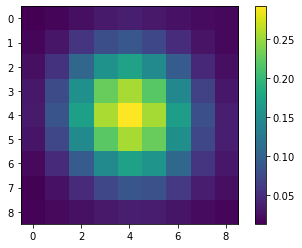

In [4]:
#from skimage.transform import resize
#psf_resized = resize(psf, (140, 54))
cx = 20
cy = 20
rx = 5
ry = 5
kernel = psf[cy-ry:cy+ry-1,cx-rx:cx+rx-1]
kernel = kernel / np.linalg.norm(kernel,ord = 'fro')
plt.imshow(kernel)
plt.colorbar()

In [5]:
class Trajectorlet(object):
    def __init__(self, shape, kernel):
        self._kernel = kernel
        self._shape = shape
        self._conv2d = pylops.signalprocessing.Convolve2D(
            N = np.prod(self._shape[-2:]),
            dims=self._shape[-2:],
            h=self._kernel,
            offset = (self._kernel.shape[0]//2+1, self._kernel.shape[1]//2+1)
        )

    def matvec(self, x):
       y = self._conv2d.matvec(x)
       return np.tile(y, (self._shape[0], 1)).flatten() # possibly just repmat here

    def rmatvec(self, y):
        x = self._conv2d.rmatvec(y.reshape(self._shape[0],-1).sum(axis=0))
        return x #np.tile(x, (self._shape[0], 1))
trajectorlet = Trajectorlet(data.shape, kernel)

In [6]:
rho_r = 0.01
rho_s = 0.1
delta = 0.5

m = data.shape[0]
n = np.prod(data.shape[-2:])

r = 20
s = 10

HTr = FixedRank(r)
HTs = Sparsity(s)

# Prepare transform
# The low-rank constraint is only a reshape a matrix to a vector operation
# The sparse constraint is the trajectorlet operation
As = (TensorLinearOperator((m,n)), trajectorlet)
b = data_mat.flatten()

In [7]:
problem = LinearProblemSum(As, b, (HTr, HTs))
solver = NAHT(logverbosity = 2, maxiter = 50)

In [9]:
x, opt_log = solver.solve(problem)

 iter		   obj. value	    grad. norm
    1	+8.5271706974357375e-02	2.04325337e-02
    2	+8.4986610076076108e-02	2.04194635e-02
    3	+8.4874971633219332e-02	2.04118136e-02
    4	+8.4882375894075768e-02	2.04090141e-02
    5	+8.4814448081901972e-02	2.04088334e-02
    6	+8.4673253179134988e-02	2.04021167e-02
    7	+8.4714379940237894e-02	2.04068348e-02
    8	+8.4354648190800408e-02	2.03928743e-02
    9	+8.4488214443270593e-02	2.03973614e-02
   10	+8.4279578136236655e-02	2.03908104e-02
   11	+8.4360707632528786e-02	2.03900971e-02
   12	+8.4225383017141997e-02	2.03870740e-02
   13	+8.4225590956066299e-02	2.03914009e-02
   14	+8.4010059525098768e-02	2.03693956e-02
   15	+8.4004941078692941e-02	2.03803144e-02
   16	+8.3965208182490869e-02	2.03755107e-02
   17	+8.3891630052734811e-02	2.03731507e-02
   18	+8.3869084435143737e-02	2.03747861e-02
   19	+8.3790607336624134e-02	2.03699619e-02
   20	+8.3637675944086443e-02	2.03614999e-02
   21	+8.3761768822860461e-02	2.03632955e-02
   22	+8.3549256346

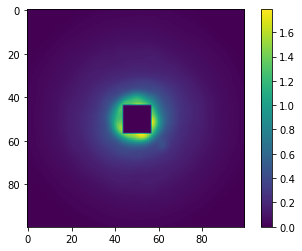

In [10]:
plt.imshow(data.sum(axis=0))
plt.colorbar()

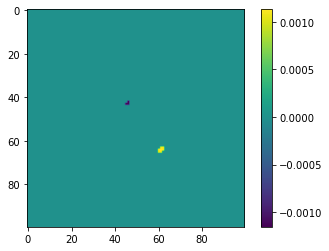

In [11]:
plt.imshow(x[1].reshape(data.shape[-2:]))
plt.colorbar()

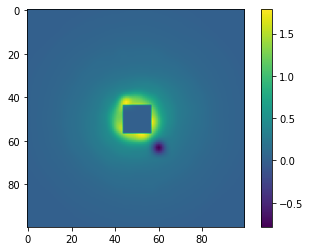

In [12]:
plt.imshow(x[0].reshape(data.shape).sum(axis=0))
plt.colorbar()

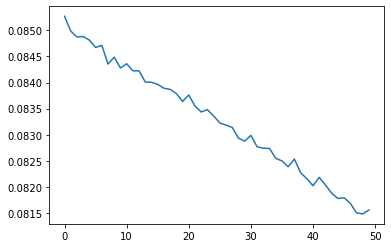

In [14]:
plt.plot(opt_log['iterations']['fx'])